In [55]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import pybloom
import csv
from collections import Counter, defaultdict
utc=pytz.UTC

ENV = "production"
os.environ['CS_ENV'] = 'production'
BASE_DIR = "/home/nathan/CivilServant"
sys.path.append(BASE_DIR)

with open(os.path.join(BASE_DIR, "config") + "/{env}.json".format(env=ENV), "r") as config:
  DBCONFIG = json.loads(config.read())

### LOAD SQLALCHEMY
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text

db_engine = create_engine("mysql://{user}:{password}@{host}/{database}".format(
    host = DBCONFIG['host'],
    user = DBCONFIG['user'],
    password = DBCONFIG['password'],
    database = DBCONFIG['database']))
DBSession = sessionmaker(bind=db_engine)
db_session = DBSession()

### LOAD PRAW
import reddit.connection
conn = reddit.connection.Connect(base_dir=BASE_DIR, env="jupyter")

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

### Goals of this Notebook
The goal of this notebook is to analyze the r/science experiment partway through

### Load PRAW session

In [2]:
r = conn.connect(controller="ModLog")

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
POST: https://api.reddit.com/api/v1/access_token/
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json


### Create a Dataset of Posts Appearing In the Experiment

In [3]:
experiment_posts = []
for row in db_engine.execute(text("select * from experiment_things JOIN posts on experiment_things.id = posts.id WHERE object_type=1 AND experiment_id=6 ORDER BY posts.created ASC;")):
    post = {}
    for key in row.keys():
        post[key]=row[key]
    metadata = json.loads(row['metadata_json'])
    for key in metadata['condition'].keys():
        post[key] = metadata['condition'][key]
    post['treat.number'] = int(post[''])
    del post['']
    del post['metadata_json']
    if post['block.id'].find("nonama") != -1:
        post['AMA'] = False
    else:
        post['AMA'] = True
    post['post_data']  = json.loads(post['post_data'])
    experiment_posts.append(post)

In [4]:
print("{0} posts have been assigned to treatment or control in the experiment.".format(len(experiment_posts)))
earliest_date = experiment_posts[0]['created']
latest_date = experiment_posts[-1]['created']

2238 posts have been assigned to treatment or control in the experiment.


In [22]:
import app.controllers.sticky_comment_experiment_controller as scec
import logging
experiment = scec.StickyCommentExperimentController("sticky_comment_science_1", 
                                                    db_session,
                                                    r,
                                                    logging.getLogger("Analysis"))
all_experiment_comments = experiment.get_comment_objects_for_experiment_comment_replies(
    experiment.get_all_experiment_comment_replies()
)

print("The whole experiment had {0} replies to experiments".format(
        len(all_experiment_comments)))

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json


The whole experiment had 307 replies to experiments


### Load Time on Top Page

In [61]:
experiment_times = {}
for row in csv.DictReader(open("outputs/experiment_posts_time_on_top.09.25.2016.csv", "r")):
    experiment_times[row['id']]=row
    
for post in experiment_posts:
    timepost = experiment_times[post['id']]
    post['sub.top.minutes'] = timepost['sub.top.minutes']
    post['sub.top.gap.size'] = timepost['sub.top.gap.size']
    
# import app.time_on_page_script as tops
# import utils.common

# counter = 0
# for post in experiment_posts:
#     counter+=1
#     if counter % 5 ==0:
#         sys.stdout.write(".")
#         sys.stdout.flush()
#     time_on_top = tops.time_on_page(
#             post['id'], "mouw", utils.common.PageType.TOP, rank_limit=5, start_time=earliest_date,
#             end_time = datetime.datetime.now()
#         )
#     post['sub.top.minute']  = time_on_top['total_time']
#     post['sub.top.gap.size']  = time_on_top['gap_size']


/home/nathan/3venv/lib/python3.5/site-packages/ipykernel/__main__.py:2: ResourceWarning: unclosed file <_io.TextIOWrapper name='outputs/experiment_posts_time_on_top.09.25.2016.csv' mode='r' encoding='UTF-8'>
  from ipykernel import kernelapp as app


### Load Moderator Actions Going Back to the Earliest Date

In [62]:
recent_mod_actions = []
for row in db_engine.execute(text('select action_data from mod_actions WHERE subreddit_id="mouw" AND created_utc >= "{0}" ORDER BY created_utc;'.format(earliest_date))):
    mod_action = json.loads(row['action_data'])
    mod_action['created'] = utc.localize(datetime.datetime.utcfromtimestamp(mod_action['created_utc']))
    recent_mod_actions.append(mod_action)
print("{0} moderator actions loaded".format(len(recent_mod_actions)))

39370 moderator actions loaded


### Tag posts as visible or non-visible based on moderation log

In [63]:
posts_2016 = {}
for post in experiment_posts:
    post['visible'] = True
    posts_2016[post['id']] = post
recent_post_count = len(posts_2016.values())
print("Post Count: {0}".format(recent_post_count))

Post Count: 2238


### Find missing posts mentioned in the moderation log

In [64]:
missing_mod_actions = []
matched_mod_actions = 0
for action in recent_mod_actions:
    if action['action'] == "removelink":
        key = action['target_fullname'].replace("t3_","")
        if key in posts_2016.keys():
            posts_2016[key]['visible'] = False
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
    elif action['action'] == 'approvelink':
        key = action['target_fullname'].replace("t3_","")
        if key in posts_2016.keys():
            posts_2016[key]['visible'] = True
            matched_mod_actions += 1
        else:
            missing_mod_actions.append(key)
#print("Missing Mod Actions: {0}".format(len(missing_mod_actions)))
print("Missing Mod Action Posts: {0}".format(len(set(missing_mod_actions))))
print("Matched Mod Actions: {0}".format(matched_mod_actions))

Missing Mod Action Posts: 1251
Matched Mod Actions: 2652


### Fetch missing posts from reddit to examine
#### Looks like the missing posts were ones that were removed immediately by automoderator

In [65]:
#extra_posts = []
#for submission in r.get_submissions(["t3_" + x for x in set(missing_mod_actions)]):
#    extra_posts.append(submission.json_dict)
#print(len(extra_posts))

### Create Dataframe to Chart Submitted versus Permitted Posts Per Day

In [66]:
recent_posts = pd.DataFrame(list(posts_2016.values()))
print("Posts before update from modlog: {0}".format(recent_post_count))
print("Posts after update from modlog: {0}".format(recent_posts.created.count()))

Posts before update from modlog: 2238
Posts after update from modlog: 2238


### Plot Posts Per Day in Experiment

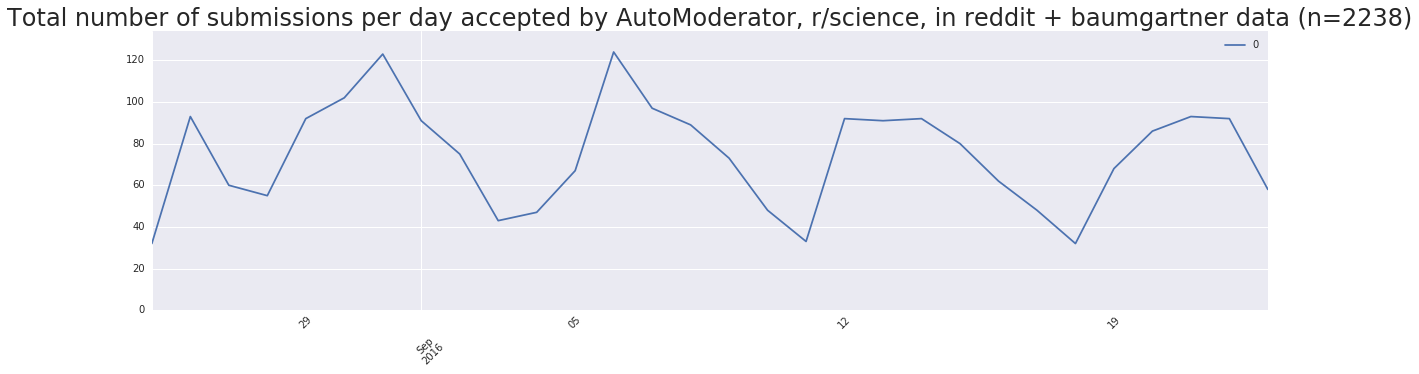

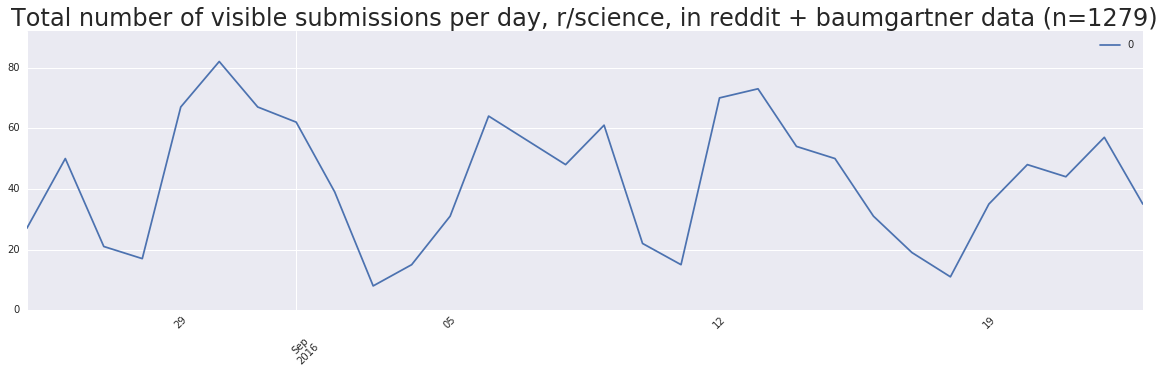

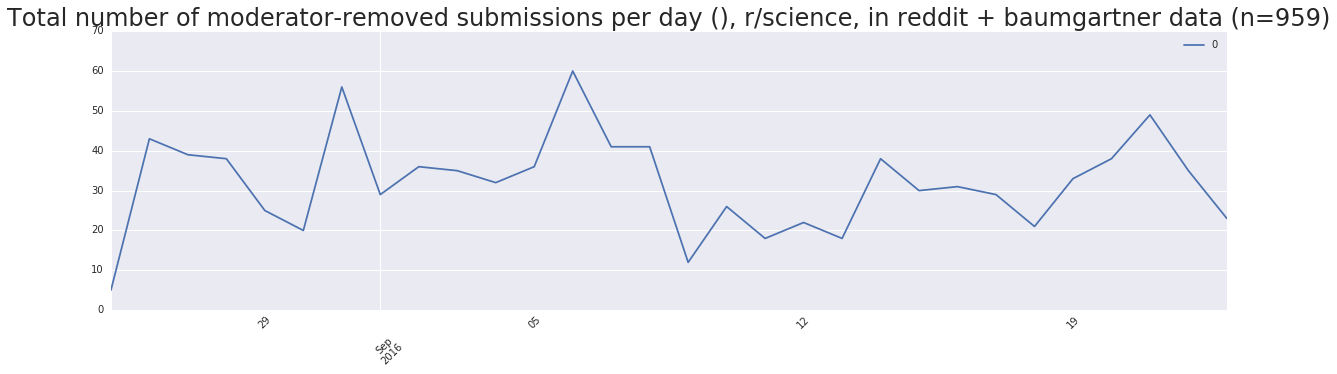

In [67]:
### TOTAL SUBMISSIONS
df = recent_posts[((recent_posts.created <= latest_date) &
                   (recent_posts.created >= earliest_date))]
x = pd.DataFrame(df.created.values, index=df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.ylim([0,x.resample("D").count()[0].max() + 10])
plt.title("Total number of submissions per day accepted by AutoModerator, r/science, in reddit + baumgartner data (n={0})".format(df.created.count()), fontsize="24")
plt.show()

total_counts = x.resample("D").count().to_dict("records")

### NOW ACCEPTED SUBMISSIONS
df = recent_posts[((recent_posts.visible == True) & 
                   (recent_posts.created <= latest_date) &
                   (recent_posts.created >= earliest_date))]
x = pd.DataFrame(df.created.values, index=df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.ylim([0,x.resample("D").count()[0].max() + 10])
plt.title("Total number of visible submissions per day, r/science, in reddit + baumgartner data (n={0})".format(df.created.count()), fontsize="24")
plt.show()

retained_counts = x.resample("D").count().to_dict("records")

### NOW REMOVED SUBMISSIONS
df = recent_posts[((recent_posts.visible == False) & 
                   (recent_posts.created <= latest_date) &
                   (recent_posts.created >= earliest_date))]
x = pd.DataFrame(df.created.values, index=df.created.values.astype('datetime64'))
fig, ax = plt.subplots(figsize=(20,5))
x.resample("D").count().plot(rot=45, ax=ax)
plt.ylim([0,x.resample("D").count()[0].max() + 10])
plt.title("Total number of moderator-removed submissions per day (), r/science, in reddit + baumgartner data (n={0})".format(df.created.count()), fontsize="24")
plt.show()

# Construct Dependent Variables: 
* newcomer comments on posts that are allowed to remain
* the number of newcomer comments on posts that are allowed to remain
* the number of removed newcomer comments on posts that are allowed to remain

### Load last six months of comments from official reddit dataset

In [68]:
comment_head = parser.parse("2015-12-01 00:00:00 UTC")
all_comments = {}
comment_ids = pybloom.BloomFilter(capacity=10000000, error_rate = .000000001)

ARCHIVE_DIR = "/home/nathan/reddit_archive"

for filename in [#'/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_12_2015.json',
#                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_01_2016.json',
#                 '/mnt/corsair/reddit_archive/official-bigquery-data/science_comments_02_2016.json',
                 ARCHIVE_DIR + '/official-bigquery-data/science_comments_03_2016.json',
                 ARCHIVE_DIR + '/official-bigquery-data/science_comments_04_2016.json',
                 ARCHIVE_DIR + '/official-bigquery-data/science_comments_05_2016.json']:
    sys.stdout.write(".")
    sys.stdout.flush()
    with open(filename, "r") as lines:
        for line in lines:
            comment = json.loads(line)
            if(comment['id'] not in comment_ids):
                comment['created'] = utc.localize(datetime.datetime.utcfromtimestamp(float(comment['created_utc'])))
                comment['visible'] = True
                if(comment['body'] == "[removed]"):
                    comment['visible'] = False
                comment['body.length'] = len(comment['body'])
                comment['body'] = None
                comment['body_html'] = None
                all_comments[comment['id']] = comment
                comment_ids.add(comment['id'])

...

### Load Baumgartner Comments from June 2016

In [69]:
## Omitting tails for this analysis
#tail = parser.parse('2016-05-30 23:59:59 UTC')
count = 0
with open(ARCHIVE_DIR + "/baumgartner-bigquery-data/baumgartner_science_comments_2016_08_01_1900.json", "r") as comment_file:
    for line in comment_file:
        comment = json.loads(line)
        if(comment['id'] not in comment_ids):
            comment['created'] = parser.parse(comment['created_utc'])
#            if(comment['created'] <= tail):
            comment['body.length'] = len(comment['body'])
            comment['body'] = None
            comment['body_html'] = None
            comment['visible'] = True
            if(comment['body'] == "[removed]"):
                comment['visible'] = False
            all_comments[comment['id']] = comment
            comment_ids.add(comment['id'])
        count += 1
        if(count % 50000 == 0):
            sys.stdout.write(".")
            sys.stdout.flush()

with open(ARCHIVE_DIR + "/baumgartner-bigquery-data/baumgartner_science_comments_2016_09_16_1500.json", "r") as comment_file:
    for line in comment_file:
        comment = json.loads(line)
        if(comment['id'] not in comment_ids):
            comment['created'] = parser.parse(comment['created_utc'])
#            if(comment['created'] <= tail):
            comment['body.length'] = len(comment['body'])
            comment['body'] = None
            comment['body_html'] = None
            comment['visible'] = True
            if(comment['body'] == "[removed]"):
                comment['visible'] = False
            all_comments[comment['id']] = comment
            comment_ids.add(comment['id'])
        count += 1
        if(count % 50000 == 0):
            sys.stdout.write(".")
            sys.stdout.flush()

......................

###  Load Comments from CivilServant

In [70]:
dbcomments = []
count = 0
for row in db_engine.execute(text("select * from comments WHERE subreddit_id='mouw';")):
    comment = {}
    for key in row.keys():
        comment[key] = row[key]
    comment_data = json.loads(comment['comment_data'])
    for key in comment_data.keys():
        comment[key] = comment_data[key]
    del comment['comment_data']
#    if(comment['link_id'].replace("t3_", "") in posts_2016.keys()):
    dbcomments.append(comment)
    
    if(comment['id'] not in all_comments.keys()):
        comment['created'] = utc.localize(datetime.datetime.utcfromtimestamp(comment['created_utc']))
#       if(comment['created'] <= tail):
        comment['body.length'] = len(comment['body'])
        comment['body'] = None
        comment['body_html'] = None
        comment['visible'] = True
        if(comment['body'] == "[removed]"):
            comment['visible'] = False
            
    count += 1
    if(count % 5000 == 0):
        sys.stdout.write(".")
        sys.stdout.flush()

................................................

In [71]:
#parser.parse(comment['created_utc'])

### Identify Missing Coments from Moderation Log

In [72]:
import re
missing_comment_ids = []
for action in recent_mod_actions:
    if action['target_fullname'] is not None and "t1_" in action['target_fullname']:
        link_id = re.search('/r/science/comments/(.*?)/', action['target_permalink']).group(1)
        if action['target_fullname'].replace("t1_", "") not in all_comments.keys():
            missing_comment_ids.append(action['target_fullname'])
print("Missing Comments: {0}".format(len(missing_comment_ids)))

Missing Comments: 7491


In [73]:
### FETCH COMMENT INFORMATION FOR ALL MISSING COMMENTS
missing_comments = []
counter = 0
for comment_obj in r.get_info(thing_id=missing_comment_ids):
    comment = comment_obj.json_dict
    comment['created'] = utc.localize(datetime.datetime.utcfromtimestamp(float(comment['created_utc'])))
    comment['visible'] = True
    if(comment['body'] == "[removed]" or comment['banned_by'] is not None):
        comment['visible'] = False
    comment['body.length'] = len(comment['body'])
    comment['body'] = None
    comment['body_html'] = None
    missing_comments.append(comment)
    counter += 1

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
POST: https://api.reddit.com/api/v1/access_token/
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/v1/me.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting h

In [75]:
print("Found {0} additional comments moderated during the newcomer period and moderation log period".format(len(missing_comments)))
print("{0} of these comments have the author [deleted]".format(len([x for x in missing_comments if x['author']=="[deleted]"])))
print("{0} of these comments were removed.".format(len([x for x in missing_comments if x['visible']==False])))
mod_action_head = recent_mod_actions[0]['created']
comments_in_comment_period = len([x for x in missing_comments if (mod_action_head < x['created'])])
print("{0} of these fall within the period covered by the moderation log.".format(comments_in_comment_period))

newcomer_head = parser.parse("2016-01-01 00:00:00 UTC")
comments_in_newcomer_period = len([x for x in missing_comments if (newcomer_head < x['created'])])
print("{0} of these fall within the period used for calculating newcomers.".format(comments_in_newcomer_period))

added_count = 0
for comment in missing_comments:
    if(comment['created'] >= newcomer_head): #and comment['created'] <= tail):
        all_comments[comment['id']] = comment
        added_count +=1
print("")
print("{0} comments added to all_comments".format(added_count))

Found 7491 additional comments moderated during the newcomer period and moderation log period
566 of these comments have the author [deleted]
6435 of these comments were removed.
7090 of these fall within the period covered by the moderation log.
7104 of these fall within the period used for calculating newcomers.

7104 comments added to all_comments


### Construct a time sorted list of comments on the sampled posts

In [76]:
import heapq

EPOCH = utc.localize(datetime.datetime.utcfromtimestamp(0))

class CommentHeapObj(object):
    def __init__(self, comment):
        self.index = int((comment['created'] - EPOCH).total_seconds())
        self.val = comment
    def __lt__(self, other):
        return self.index < other.index

def heapsort(comments):
    h = []
    for comment in comments:
        heapq.heappush(h, CommentHeapObj(comment))
    return [heapq.heappop(h).val for i in range(len(h))]

all_comments = heapsort(all_comments.values())

### Add Moderation Actions to Comments, Setting Comments as Visible or Not Visible

In [77]:
from collections import defaultdict, Counter
mod_comment_actions = defaultdict(list)
approved_count = 0
removed_count = 0
total_coments_removed_at_least_once = []
comments_with_mod_actions = set()

for action in recent_mod_actions:
     if action['action'] == "removecomment" or action['action'] == "approvecomment":
            comment_id = action['target_fullname'].replace("t1_", "")
            mod_comment_actions[comment_id].append(action)
            comments_with_mod_actions.add(action['target_fullname'])

print("{0} Total moderation actions".format(sum([len(x) for x in mod_comment_actions.values()])))
print("{0} Comments with moderation actions".format(len(mod_comment_actions)))
print("{0} Comments with more than one mod action".format(len([x for x in mod_comment_actions.values() if len(x)>1])))
print("")

for comment in all_comments:
    if('later_deleted' not in comment.keys()):
        comment['later_deleted'] = False
        if(comment['author'] =="[deleted]"):
            comment['later_deleted'] = True
    if comment['id'] in mod_comment_actions.keys():
        for action in mod_comment_actions[comment['id']]:
            ## many authors are later deleted, so try to 
            ## add in the author information here, since
            ## the moderation log retains the author information
            comment['author']  = action['target_author']
            if action['action'] =="removecomment":
                removed_count += 1
                total_coments_removed_at_least_once.append(comment['id'])
                comment['visible'] = False
            elif action['action'] == "approvecomment":
                approved_count += 1
                comment['visible']  = True
print("Summary of Comment Visibility:")
print(Counter([x['visible'] for x in all_comments]))
print("Took {0} actions to set a comment to removed".format(removed_count))
print("Took {0} actions to set a comment to approved".format(approved_count))

31600 Total moderation actions
28619 Comments with moderation actions
2674 Comments with more than one mod action

Summary of Comment Visibility:
Counter({True: 521015, False: 129450})
Took 30054 actions to set a comment to removed
Took 1159 actions to set a comment to approved


### Add Author Comment Number to All Comments

In [78]:
author_comment_num = defaultdict(int)

for comment in all_comments:
    comment['author.prev.comments'] = author_comment_num[comment['author']]    
    author_comment_num[comment['author']] += 1

### Add Author Removed Count to All Comments

In [79]:
from collections import defaultdict, Counter

author_removed_num = defaultdict(int)

for comment in all_comments:
    comment['author.prev.removed'] = author_removed_num[comment['author']]  
    if(comment['visible']==False):
        author_removed_num[comment['author']] += 1

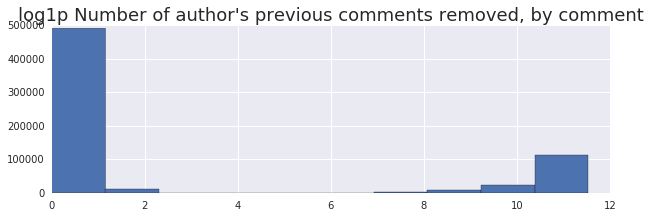

In [80]:
import math
plt.figure(figsize=(10, 3)) 
plt.hist([math.log1p(x['author.prev.removed']) for x in all_comments])
plt.title("log1p Number of author's previous comments removed, by comment", fontsize="18")
plt.show()

# Create Dataframes for Analysis

### Create a Dataset of Comments from The Front Page Observation Period forward
Tagged comments with information about the post they were attached to, including:
* were they top-level comments or replies?
* what flair did the post have
* what time was the post made
* was the post removed

#### Fetch full post information for all posts

In [81]:
all_post_ids = ["t3_" + post_id for post_id in posts_2016.keys()]
additions = 0
for post_object in r.get_info(thing_id=all_post_ids):
    post = post_object.json_dict
    for key in post.keys():
        if key not in posts_2016[post['id']].keys():
            posts_2016[post['id']][key] = post[key]
            additions += 1
print("{0} fields updated".format(additions))

substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com in url
GET: https://oauth.reddit.com/api/info/.json
substituting https://oauth.reddit.com for https://api.reddit.com

0 fields updated


#### Now attach post-level covariates to comments

In [82]:
all_experiment_comment_ids = [x.id for x in all_experiment_comments]
print(len(all_experiment_comment_ids))

307


In [83]:
def is_ama(flair, block):
    if(flair is None or (isinstance(flair, str))!=True):
        return None
    if("ama" in flair and block.find("nonama")==-1):
        return True
    return False

def is_badpost(flair):
    if(flair is None or (isinstance(flair, str))!=True):
        return None
    return "badpost" in flair

def strip_ama(flair):
    if(flair is None or (isinstance(flair, str))!=True):
        return None
#    try:
    flairs = [x for x in flair.split() if("ama" not in x and "badpost" not in x)]
#    except:
#        import pdb;pdb.set_trace()
    if(len(flairs)==0):
        return None
    return flairs[0] ## Confirmed that this is always only one flair

recent_comments_included = []
experiment_comments = []
for comment in all_comments:
    if(comment['author'] == "CivilServantBot"):
        experiment_comments.append(comment)
        continue
    post_id = comment['link_id'].replace("t3_", "")
    if(post_id in posts_2016.keys()):
        post = posts_2016[comment['link_id'].replace("t3_", "")]
        post_created = utc.localize(post['created'])
        comment['intervention.reply'] = comment['id'] in all_experiment_comment_ids
        comment['post.ama'] = is_ama(post['link_flair_css_class'], post['block.id'])
        comment['post.badpost'] = is_badpost(post['link_flair_css_class'])
        comment['post.flair'] = strip_ama(post['link_flair_css_class'])
        comment['post.created'] = post['created']
        comment['minutes.since.post.created'] = (comment['created'] - post_created).total_seconds() / 60.
#         comment['post.sub.top.minutes'] = post['post.sub.top.minutes']
#         comment['post.sub.top.gap.size'] = post['post.sub.top.gap.size']
        comment['post.author'] = post['author']
        comment['post.visible'] = post['visible']
        comment['toplevel'] = comment['link_id'] == comment['parent_id']
        comment['post.domain'] = post['domain']
        comment['post.day.num']  = (post_created - utc.localize(datetime.datetime(1970,1,1))).days
        comment['day.num'] = (comment['created'] - utc.localize(datetime.datetime(1970,1,1))).days
        comment['weekday'] = comment['created'].weekday()
        comment['weekend'] = (comment['weekday'] >=6)
        comment['post.treatment'] = int(post['treatment'])
        comment['post.assign.number']  = int(post['treat.number'])
        comment['post.block.id'] = post['block.id']
        comment['post.block.size']  = post['block.size']

        recent_comments_included.append(comment)


In [87]:
print("Comments Included: {0}".format(len(recent_comments_included)))
print("Experiment Comments made by CivilServant: {0}".format(len(experiment_comments)))

Comments Included: 71074
Experiment Comments made by CivilServant: 1115


In [85]:
#c = Counter([x['author'] for x in all_comments])

In [51]:
#c['CivilServantBot']

In [88]:
import time
recent_comment_df = pd.DataFrame(recent_comments_included)
recent_comments_filename = "r_science_comments_science_sticky_09.25.2016.csv"
recent_comment_df.to_csv(os.path.join("outputs",recent_comments_filename))

In [89]:
print("{0} comments by newcomers".format(recent_comment_df[recent_comment_df['author.prev.comments']==0].created.count()))
#print("{0} newcomer comments that were removed")
print("{0} comments by newcomers that were removed".format(recent_comment_df[((recent_comment_df['author.prev.comments']==0) & (recent_comment_df.visible==False))].created.count()))
print("{0} comments by newcomers that were removed, whose accounts were not later deleted".format(recent_comment_df[((recent_comment_df['author.prev.comments']==0) & (recent_comment_df.visible==False) & (recent_comment_df.later_deleted==False))].created.count()))

20837 comments by newcomers
10283 comments by newcomers that were removed
7346 comments by newcomers that were removed, whose accounts were not later deleted


In [ ]:
amas = [x for x in list(posts_2016.values()) if is_ama(x['link_flair_css_class'], x['block.id'])]

In [ ]:
np.sum([x['num_comments'] for x in amas])

#### Now Generate and output a post-level dataset

In [90]:
#recent_comments[0]['created']
#next_period_start = (recent_comments_included[0]['created'] + datetime.timedelta(days=1)).replace(hour = 10, minute=0, second=0)
print(next_period_start)
#datetime.timedelta(days=1).total_seconds()
#day_later - datetime.timedelta(hours = day_later.hour, minutes = day_later)

2016-08-26 10:00:00+00:00


86400.0

In [93]:
# from comment_head onward
#post_comments = {}
for post in posts_2016.values():
#    post['newcomer.commenters'] = set()
    post['newcomer.comments'] = 0
    post['newcomer.comments.experiment.day'] = 0
    post['newcomer.comments.experiment.after'] = 0

    post['newcomer.comments.removed'] = 0
    post['newcomer.comments.removed.experiment.day'] = 0
    post['newcomer.comments.removed.experiment.after'] = 0

    post['commenters'] = set()
    
    post['experiment.day'] = post['created'].replace(hour = 5, minute=0, second=0)
    post['experiment.day.next'] = (post['experiment.day'] + datetime.timedelta(days=1))
    post['experiment.day.minutes'] = int((post['experiment.day.next'] - post['created']).total_seconds() / 60.)
                                   
#     post['num.comments.experiment.day'] = 0
#     post['num.comments.experiment.after'] = 0
                                   
    post['num.comments']  = 0
    post['num.comments.removed'] = 0
    post['num.comments.removed.experiment.day'] = 0
    post['num.comments.removed.experiment.after'] = 0
    
    post['num.comments.experiment.replies'] = 0
    post['newcomer.comments.experiment.replies'] = 0
                                   
    post['post.ama'] = is_ama(post['link_flair_css_class'], post['block.id'])
    post['post.badpost'] = is_badpost(post['link_flair_css_class'])
    post['post.flair'] = strip_ama(post['link_flair_css_class'])
    post['weekday'] = post['created'].weekday()
    post['weekend'] = (post['weekday'] >=6)
    
for comment in recent_comments_included:
    post = posts_2016[comment['link_id'].replace("t3_", "")]
    post['commenters'].add(comment['author'])
    
    
    if(comment['id'] in all_experiment_comment_ids):
        post['num.comments.experiment.replies'] += 1
    else:
        post['num.comments'] += 1
#     if(comment['created'] <= post['experiment.day.next']):
#         post['num.comments.experiment.day'] += 1 
#     else:
#         post['num.comments.experiment.after'] += 1
    
    if(comment['visible']!=True):
        post['num.comments.removed'] +=1
#         if(comment['created'] <= post['experiment.day.next']):
#             post['num.comments.removed.experiment.day'] += 1
#         else:
#             post['num.comments.removed.experiment.after'] += 1            
        
    ## IF THE COMMENT AUTHOR IS A NEWCOMER
    if comment['author.prev.comments'] == 0:
        post['newcomer.comments'] += 1
        
        if(comment['id'] in all_experiment_comment_ids):
            post['newcomer.comments.experiment.replies'] += 1
        
#         if(comment['created'] <= post['experiment.day.next']):
#             post['newcomer.comments.experiment.day'] += 1
#         else:
#             post['newcomer.comments.experiment.after'] += 1
        
        if(comment['visible']!=True):
            post['newcomer.comments.removed'] += 1
    
#             if(comment['created'] <= post['experiment.day.next']):
#                 post['newcomer.comments.removed.experiment.day'] += 1
#             else:
#                 post['newcomer.comments.removed.experiment.after'] += 1


for post in posts_2016.values():
    post['num.commenters'] = len(post['commenters'])
    del post['commenters']

In [95]:
print("{0} posts overall".format(len(list(posts_2016.values()))))
#print("{0} posts within the analysis period".format(len([x for x in posts_2016.values() if (x['created'] > comment_head and x['created'] <= tail)])))

2238 posts overall


In [98]:
recent_post_df = pd.DataFrame([x for x in posts_2016.values()])
recent_posts_filename = "r_science_experiment_1_posts.09.26.2016.csv"
recent_post_df.to_csv(os.path.join("outputs", recent_posts_filename))

### Additional Analyses: Missing Observations in Blocks

In [122]:
### OBSERVE BLOCKS WITH MISSING OBSERVATIONS
counts = Counter([x['block.id'] for x in posts_2016.values()])
print("These Blocks Have Missing Values and Should Be Removed in Analysis")
for key in counts.keys():
    value = counts[key]
    if(value <10 and key.find("nonama")>-1):
        print("{0}:{1}".format(key,value))
        

These Blocks Have Missing Values and Should Be Removed in Analysis
nonama.block037:9
nonama.block222:6
nonama.block058:9


### Additional Analysis: Plot the Experience Associated with Removed Comments

In [133]:
prev_comments_list = sorted(recent_comment_df[recent_comment_df.visible==True]['author.prev.comments'].tolist())
total_removed = len(prev_comments_list)
pct_cutoff = total_removed*0.75
counter = 0
prev_comments_ninety = 0
for prev in prev_comments_list:
    counter+=1
    prev_comments_cutoff = prev
    if(counter>pct_cutoff):
        break
prev_comments_cutoff

58